<a href="https://colab.research.google.com/github/Suhas-G/colab-notebooks/blob/main/unicorn_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **UNICORN 🦄 - 3D car reconstruction example 🚘**

In this notebook, we will use a pre-trained [UNICORN](http://imagine.enpc.fr/~monniert/UNICORN/) checkpoint to reconstruct 3D cars from single-view images. 

First, make sure the notebook is **running on GPU** (`Runtime` > `Change runtime type` > `Hardware accelerator` > `GPU`).

## **1. Setup 👷**

The following cell will setup the notebook environment by cloning the UNICORN repo and downloading the pre-trained model:

In [ ]:
print('Cloning unicorn repository...')
!git clone --quiet https://github.com/monniert/unicorn.git
print('unicorn repository cloned!')

# Import
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import torch

# Install
print('Installing packages...')
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip -q install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
!pip -q install gdown
print('Packages installed!')

# Path + download pretrained model
print('Downloading pretrained model...')
os.chdir('unicorn')
sys.path.append('./src')
!gdown 1i7HF8EhI--EeES8X8GfN2wDzopulV5Z7 -O car_big.pkl
print('Model downloaded!')

Cloning unicorn repository...
unicorn repository cloned!
Installing packages...
     |████████████████████████████████| 45.7 MB 992 kB/s 
     |████████████████████████████████| 50 kB 4.2 MB/s 
     |████████████████████████████████| 42 kB 986 kB/s 
Packages installed!
Downloading...
From: https://drive.google.com/uc?id=1i7HF8EhI--EeES8X8GfN2wDzopulV5Z7
To: /content/unicorn/car_big.pkl
100% 645M/645M [00:13<00:00, 48.0MB/s]
Model downloaded!


## **2. Loading the model ⌛**

In [ ]:
from model import load_model_from_path
from utils.pytorch import get_torch_device
from utils.logger import print_log

device = get_torch_device()
m = load_model_from_path('car_big.pkl').to(device).eval()
print_log(f"Model loaded: input img_size is set to {m.init_kwargs['img_size']}")

[2022-10-07 14:26:43] progressive field activated powers=[]
[2022-10-07 14:26:43] progressive giraffe gen active powers=[2]
[2022-10-07 14:26:43] init_rotations: azim=[0.0, 60.0, 120.0, 180.0, 240.0, 300.0], elev=[10.0, 10.0, 10.0, 10.0, 10.0, 10.0], roll=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[2022-10-07 14:26:43] progressive giraffe gen active powers=[4]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

[2022-10-07 14:26:47] WARN load_state_dict: ['T_init'] not found
[2022-10-07 14:26:47] progressive field activated powers=[2, 8, 64]
[2022-10-07 14:26:47] progressive giraffe gen active powers=[2, 8, 64, 512]
[2022-10-07 14:26:47] progressive giraffe gen active powers=[4, 8, 64, 256]
[2022-10-07 14:26:47] Model loaded: input img_size is set to (64, 64)


## **3. Preparing the data 🍪**

In [ ]:
# Uncomment the following lines if you want to load your custom images
# %cd demo
# from google.colab import files
# image = files.upload()
# %cd ..

In [ ]:
from torch.utils.data import DataLoader
from dataset import get_dataset


BATCH_SIZE = 32
N_WORKERS = 2
FOLDER_NAME = 'demo'


data = get_dataset(FOLDER_NAME)(split="test", img_size=m.init_kwargs['img_size'])
loader = DataLoader(data, batch_size=BATCH_SIZE, num_workers=N_WORKERS, shuffle=False)
print_log(f"Found {len(data)} images in the {FOLDER_NAME} folder")

[2022-08-17 15:57:01] Found 7 images in the demo folder


## **4. Inference 🚀**

In [ ]:
from model.renderer import save_mesh_as_gif
from utils import path_mkdir
from utils.mesh import save_mesh_as_obj, normalize



PRINT_ITER = 2
SAVE_GIF = True


print_log("Starting reconstruction...")
out = path_mkdir(FOLDER_NAME + '_rec')
for j, (inp, _) in enumerate(loader):
    imgs = inp['imgs'].to(device)
    meshes = m.predict_mesh_pose_bkg(imgs)[0]

    B, d, e = len(imgs), m.T_init[-1], np.mean(m.elev_range)
    for k in range(B):
        nb = j*B + k
        if nb % PRINT_ITER == 0:
            print_log(f"Reconstructed {nb} images...")
        name = data.input_files[nb].stem
        mcenter = normalize(meshes[k])
        save_mesh_as_obj(mcenter, out / f'{name}_mesh.obj')
        if SAVE_GIF:
            save_mesh_as_gif(mcenter, out / f'{name}_mesh.gif', n_views=50, dist=d, elev=e, renderer=m.renderer)

[2022-08-17 15:57:23] Starting reconstruction...
[2022-08-17 15:57:23] Reconstructed 0 images...
[2022-08-17 15:57:26] Reconstructed 2 images...
[2022-08-17 15:57:29] Reconstructed 4 images...
[2022-08-17 15:57:33] Reconstructed 6 images...


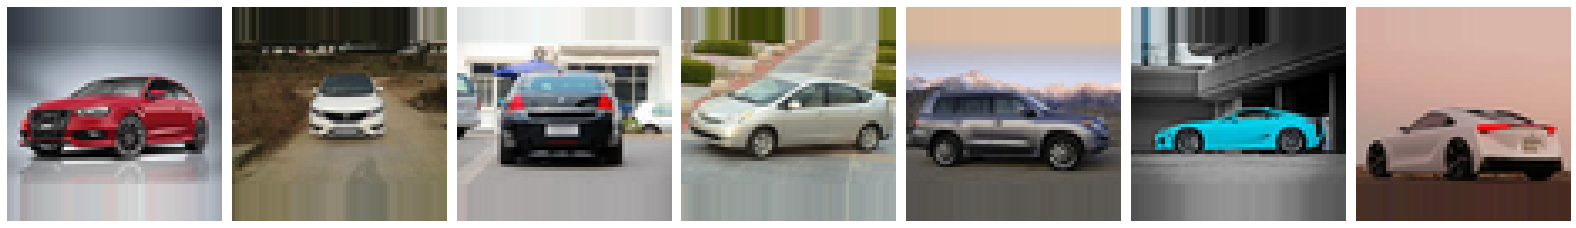

In [ ]:
from utils.plot import plot_img_grid
N = len(data)
imgs = []
for k in range(min(N, 10)):
    imgs.append(data[k][0]['imgs'])
plot_img_grid(torch.stack(imgs, dim=0))

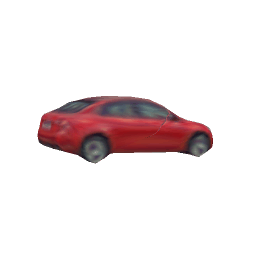

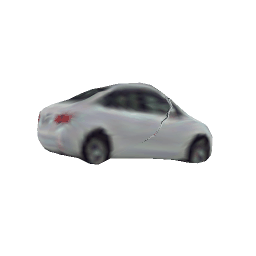

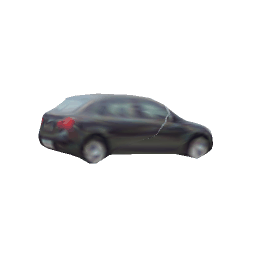

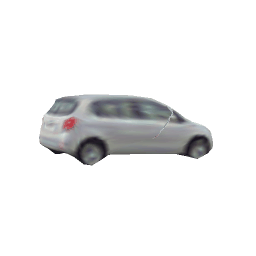

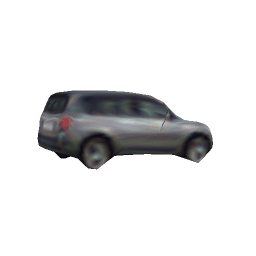

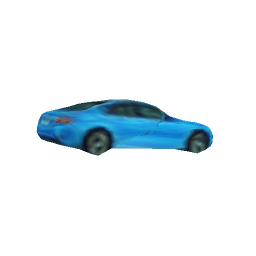

In [ ]:
# XXX do sign in with your gmail account to see the visualization outputs
from utils.image import convert_to_img
from IPython.display import Image, display, HTML
style = "<style>#output-body{display:flex; flex-direction: row;}</style>"
display(HTML(style))
for k in range(min(N, 10)):
    stem = data.input_files[k].stem
    display(Image(open(f'{FOLDER_NAME}_rec/{stem}_mesh.gif','rb').read(), width=200, height=200))